In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn

import tensorflow as tf



from itertools import product

In [2]:
import warnings
import itertools

In [3]:
data_raw = pd.read_csv('./data/USD_CNY_Historical_Data.csv')

# filter out holidays. During hoildays, high = low in my source

In [31]:
data_name = 'USD-CNY'
attention_flag = False
train_len = int(len(data_raw)*0.3)
seq_length = 16
num_epochs = 100

In [32]:
ARIMA_Train = data_raw.loc[:,['Price']][0:train_len]
ARIMA_Test =  data_raw.loc[:,['Price']][train_len:]
ARIMA_Test_Input = data_raw.loc[:,['Date']][train_len:]

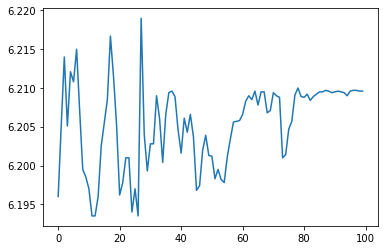

In [33]:
ARIMA_mean_log = np.log(data_raw.loc[:,['Price']])
plt.plot(ARIMA_Train.iloc[:100])

In [34]:
X = ARIMA_Train.values
result = adfuller(X)
d=-1
print('d=0')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1]<=0.05:
    d=0
else:
    for i in range(1,4):
        X=pd.DataFrame(X)
        X=X-X.shift(periods=1)
        X=X.dropna()
        X=np.array(X)
        result = adfuller(X)
        print('d=%f' % i)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[1]<=0.05:
            d=i
            break

d=0
ADF Statistic: -1.388246
p-value: 0.587898
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
d=1.000000
ADF Statistic: -7.649417
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [35]:
 warnings.filterwarnings("ignore")
 q_arima = range(0, 3)
 d_arima=d
 p_arima = range(0, 8)
 AIC_arima = []
 ARIMAX_model = []
 pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]

 for pdq in pdqs:
     try:
         mod = ARIMA(ARIMA_Train,order=pdq)

         results = mod.fit()
         print('ARIMAX{} - AIC:{}'.format(pdq, results.aic))
         AIC_arima.append(results.aic)
         ARIMAX_model.append([(1,1,0), pdq])
     except:
             continue

ARIMAX(0, 1, 0) - AIC:-4544.066011663003
ARIMAX(0, 1, 1) - AIC:-4550.762536174539
ARIMAX(0, 1, 2) - AIC:-4555.599924421773
ARIMAX(1, 1, 0) - AIC:-4549.080972651629
ARIMAX(1, 1, 1) - AIC:-4557.117116984033
ARIMAX(1, 1, 2) - AIC:-4555.356403275861
ARIMAX(2, 1, 0) - AIC:-4554.117681806774
ARIMAX(2, 1, 1) - AIC:-4555.346060203369
ARIMAX(2, 1, 2) - AIC:-4553.356405983091
ARIMAX(3, 1, 0) - AIC:-4557.36610079545
ARIMAX(3, 1, 1) - AIC:-4558.829519773291
ARIMAX(3, 1, 2) - AIC:-4559.133423612702
ARIMAX(4, 1, 0) - AIC:-4557.802454618551
ARIMAX(4, 1, 1) - AIC:-4556.834782469198
ARIMAX(4, 1, 2) - AIC:-4556.409403085886
ARIMAX(5, 1, 0) - AIC:-4557.52613492692
ARIMAX(5, 1, 1) - AIC:-4557.942599138935
ARIMAX(5, 1, 2) - AIC:-4555.992355773518
ARIMAX(6, 1, 0) - AIC:-4557.216346543744
ARIMAX(6, 1, 1) - AIC:-4556.015227545178
ARIMAX(6, 1, 2) - AIC:-4554.016726760456
ARIMAX(7, 1, 0) - AIC:-4556.344520488937
ARIMAX(7, 1, 1) - AIC:-4556.068749657793
ARIMAX(7, 1, 2) - AIC:-4559.342659546948


In [36]:
order = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]
print(order)
model = ARIMA(ARIMA_Train, order)
fit = model.fit()

(7, 1, 2)


In [37]:
preds = fit.predict(1,len(data_raw),typ='levels')
preds_pd = preds.to_frame()
preds_pd.index -= 1
print(preds_pd)

             0
0     6.196110
1     6.206165
2     6.214144
3     6.204054
4     6.214978
...        ...
1578  6.367725
1579  6.367835
1580  6.367945
1581  6.368055
1582  6.368165

[1583 rows x 1 columns]


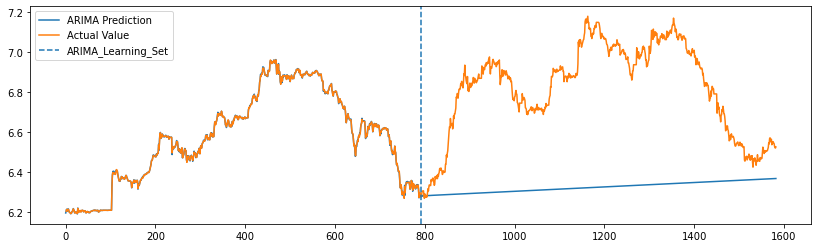

In [38]:
# draw predict figure
plt.figure(figsize=(14, 4))
plt.plot(preds_pd,label="ARIMA Prediction")
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.plot(data_raw.iloc[1:]["Price"],label="Actual Value")
plt.axvline(x=train_len,  linestyle='--',label="ARIMA_Learning_Set")
plt.legend()
#plt.savefig('./2015—50%ARIMA.jpg')
plt.show()

In [39]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ARIMA_Result['raw'] = data_raw['Price']
ARIMA_Result['predicted'] = preds_pd
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
ARIMA_Result

,raw,predicted,residuals
0,6.1960,6.196110,-0.000110
1,6.2052,6.206165,-0.000965
2,6.2140,6.214144,-0.000144
3,6.2051,6.204054,0.001046
4,6.2121,6.214978,-0.002878
...,...,...,...
1578,6.5431,6.367725,0.175375
1579,6.5292,6.367835,0.161365
1580,6.5220,6.367945,0.154055
1581,6.5203,6.368055,0.152245


In [40]:
LSTM_data = ARIMA_Result
ARIMA_close_prices = LSTM_data['residuals'][train_len:].values.astype(float)


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [41]:
# %% split data for training and testing
def split_data(stock, lookback, test_percentage):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(test_percentage*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test,train_set_size]

In [42]:
Price_scaler = MinMaxScaler(feature_range=(-1, 1))
ARIMA_close_prices = Price_scaler.fit_transform(ARIMA_close_prices.reshape(-1,1))

In [43]:
lookback = 50  # choose sequence length for history value
x_train, y_train, x_test, y_test,train_set_size = split_data(ARIMA_close_prices, lookback, 0.3)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (519, 49, 1)
y_train.shape =  (519, 1)
x_test.shape =  (223, 49, 1)
y_test.shape =  (223, 1)


In [44]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [45]:
input_dim = 1
hidden_dim = 32 # hidden nums
num_layers = 2
output_dim = 1
num_epochs = 100

In [46]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:

# %% train LSTM model
loss_record = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, ", MSE: ", loss.item(), end='\r')
    loss_record[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time() - start_time
print("Training time: {}".format(training_time))



Training time: 14.785950899124146927197


In [48]:
# %% prediction on test dataset
y_test_pred = model(x_test)

# inverse predictions
y_train_pred = Price_scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = Price_scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = Price_scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = Price_scaler.inverse_transform(y_test_lstm.detach().numpy())




In [49]:
predict=LSTM_data['predicted'][train_len+train_set_size+lookback:].values.astype(float)+y_test_pred.reshape(-1)

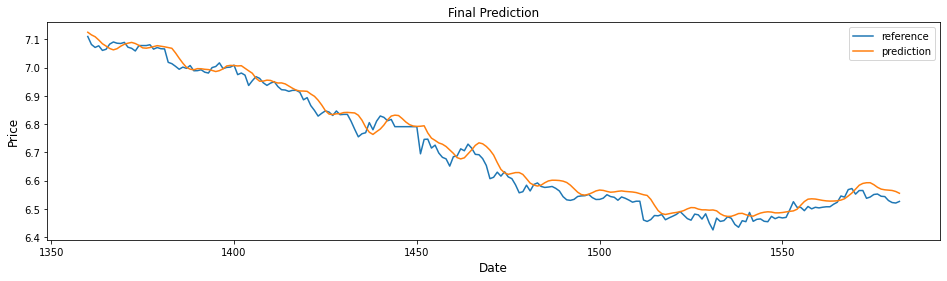

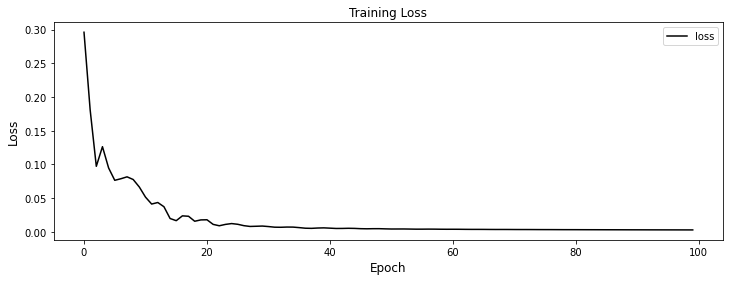

X_test MSE: 0.0010006396457462523
X_test MAE: 0.025091974971966375
X_test RMSE: 0.03163288867217555
X_test RMSLE: 0.004126922132456472


In [50]:
# %% plot on training dataset
fig = plt.figure(figsize=(16, 4))

plt.plot(LSTM_data['raw'][train_len+train_set_size+lookback:],  label='reference')
plt.plot(range(train_len+train_set_size+lookback,len(LSTM_data['raw'])),predict,  label='prediction')
plt.title('Final Prediction', size=12)
plt.xlabel('Date', size=12)
plt.ylabel('Price', size=12)
plt.legend()
#plt.savefig('./2015—50%LSTM.jpg')
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.plot(loss_record, 'b', label='loss',color='black')
plt.title('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend()
#plt.savefig('./2015—50%LSTM-loss.jpg')
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

mse = mean_squared_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict)     
mae = mean_absolute_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict)
rmse = np.sqrt(mse)
rmsle = np.sqrt(mean_squared_log_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict))


print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RMSLE: {rmsle}')

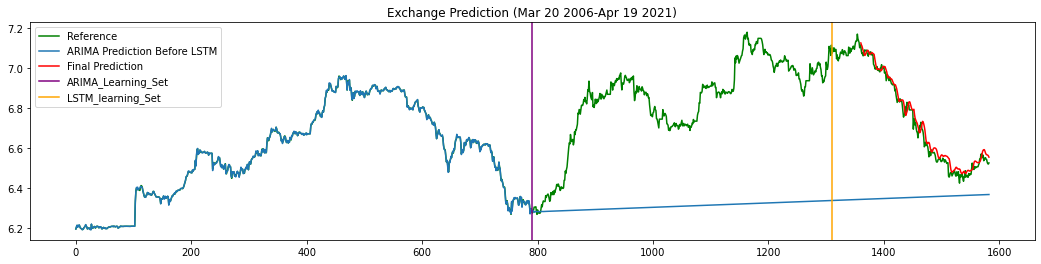

In [52]:
# draw predict figure

plt.figure(figsize=(18, 4))
plt.plot(LSTM_data['raw'],label="Reference",color='green')
plt.plot(preds_pd,label="ARIMA Prediction Before LSTM")
plt.plot(range(train_len+train_set_size+lookback,len(LSTM_data['raw'])),predict,color='red', label='Final Prediction')
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.axvline(x=train_len,color='purple',label="ARIMA_Learning_Set")
plt.axvline(x=train_len+train_set_size, color='orange',label="LSTM_learning_Set")
plt.title('Exchange Prediction (Mar 20 2015-Apr 19 2021)', size=12)
plt.legend()
plt.savefig('./2015—30%all.jpg')
plt.show()

12961